# XGBoost Regression

## Setup

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pandas as pd
import pyarrow.parquet as pq
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import lightgbm as lgb
import pickle

In [2]:
df_final = pd.read_parquet('../data/final/final_data.parquet').dropna()

In [3]:
len(df_final)

5656152

In [4]:
df_final.columns

Index(['FlightDate', 'DayOfWeek', 'Month', 'Airline', 'Origin', 'Dest',
       'Cancelled', 'Diverted', 'DivAirportLandings', 'CRSDepTime', 'DepTime',
       'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDel15',
       'AirTime', 'Distance', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn',
       'DelayCategory', 'AirTimeCategory', 'TimeofDay', 'Month_sin',
       'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'DayOfYear',
       'DayOfYear_sin', 'DayOfYear_cos', 'Holiday_Indicator', 'Near_Holiday',
       'Origin_PRCP', 'Origin_SNOW', 'Origin_SNWD', 'Origin_TMAX',
       'Origin_TMIN', 'Dest_PRCP', 'Dest_SNOW', 'Dest_SNWD', 'Dest_TMAX',
       'Dest_TMIN', 'weekly_avg_origin_tmin', 'weekly_avg_dest_tmin',
       'monthly_avg_origin_tmin', 'monthly_avg_dest_tmin',
       'weekly_avg_origin_tmax', 'weekly_avg_dest_tmax',
       'monthly_avg_origin_tmax', 'monthly_avg_dest_tmax',
       'weekly_avg_origin_prcp', 'weekly_avg_dest_prcp',
       'monthly_avg_origin_prcp', 'm

In [5]:
# Edit DepDelay to have a baseline of 0 (early flights are now considered on-time)
df_final['DepDelay'] = df_final['DepDelay'].clip(lower=0)

In [6]:
# Grab target variables
y = df_final[['DepDelay']]

In [7]:
# Grab explanatory variables
X = df_final[['DayOfWeek', 'Month', 'CRSDepTime', 'CRSArrTime', 'AirTime',
            'Distance', 'Origin_PRCP', 'Origin_SNOW', 'Origin_SNWD', 
            'Origin_TMAX', 'Origin_TMIN', 'Dest_PRCP', 'Dest_SNOW', 
            'Dest_SNWD', 'Dest_TMAX', 'Dest_TMIN']]

In [8]:
# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Plain XGBoost

In [15]:
# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

In [16]:
# Train the model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
### ER - BEGIN ###
with open("../models/xgb_reg.pkl", "wb") as file:
    pickle.dump(xgb_reg, file)

In [52]:
with open("../models/xgb_reg.pkl", "rb") as file:
    xgb_reg = pickle.load(file)
### ER - END ###

In [53]:
# Make predictions
y_pred = xgb_reg.predict(X_test)

In [54]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 37.34177799707435
Root Mean Squared Error (RMSE): 73.45164862972936


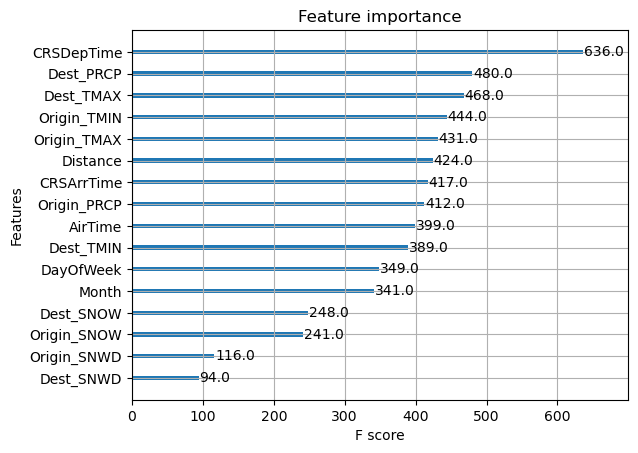

In [55]:
# Plot feature importance
xgb.plot_importance(xgb_reg)
plt.show()

In [56]:
# Baseline model: Predict the mean of y_true for all instances
y_baseline = np.full_like(y_test, fill_value=np.mean(y_train))

# Compute MAE
mae_model = mean_absolute_error(y_test, y_pred)
mae_baseline = mean_absolute_error(y_test, y_baseline)

# Print results
print(f"Baseline MAE (Mean Predictor): {rmse_baseline:.4f}")
print(f"Your Model's MAE: {mae_model:.4f}")
print(f"Improvement over Baseline: {(1 - mae_model/mae_baseline) * 100:.2f}%")
print(f"Linear Regression R2 Score on Test Set:", r2_score(y_test, y_pred))

Baseline MAE (Mean Predictor): 75.3251
Your Model's MAE: 37.3418
Improvement over Baseline: 5.32%
Linear Regression R2 Score on Test Set: 0.04912562992834857


In [57]:
# Compute RMSE
rmse_model = root_mean_squared_error(y_test, y_pred)
rmse_baseline = root_mean_squared_error(y_test, y_baseline)

# Print results
print(f"Baseline RMSE (Mean Predictor): {rmse_baseline:.4f}")
print(f"Your Model's RMSE: {rmse_model:.4f}")
print(f"Improvement over Baseline: {(1 - rmse_model/rmse_baseline) * 100:.2f}%")

Baseline RMSE (Mean Predictor): 75.3251
Your Model's RMSE: 73.4516
Improvement over Baseline: 2.49%


## Log Transformed Target XGBoost

In [25]:
# Initialize the XGBoost Regressor
xgb_reg_logy = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

In [26]:
y_train_transformed = np.log1p(y_train)  # log(1 + y) to avoid log(0) issues

In [27]:
# Train the model
xgb_reg_logy.fit(X_train, y_train_transformed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
### ER - BEGIN ###
with open("../models/xgb_reg_log.pkl", "wb") as file:
    pickle.dump(xgb_reg_logy, file)

In [58]:
with open("../models/xgb_reg_log.pkl", "rb") as file:
    xgb_reg_logy = pickle.load(file)
### ER - END ###

In [59]:
y_pred_transformed = xgb_reg_logy.predict(X_test)
y_pred_logy = np.expm1(y_pred_transformed)  # Reverse transformation

In [60]:
mae = mean_absolute_error(y_test, y_pred_logy)
rmse = root_mean_squared_error(y_test, y_pred_logy)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 32.63179941807334
Root Mean Squared Error (RMSE): 78.61112237103723


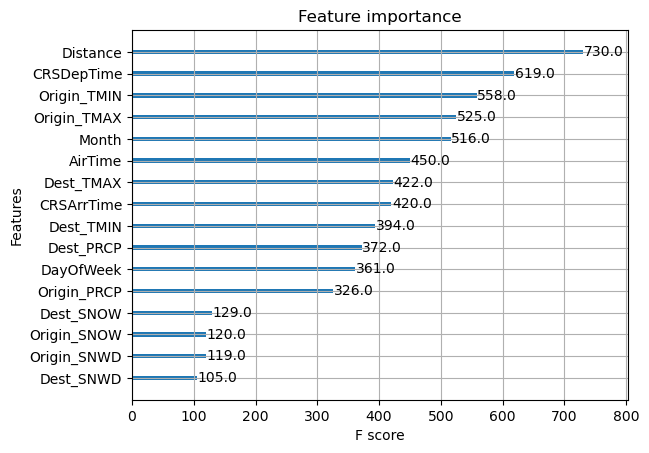

In [61]:
# Plot feature importance
xgb.plot_importance(xgb_reg_logy)
plt.show()

## MAE focused XGBoost

In [40]:
# Initialize the XGBoost Regressor
xgb_reg_mae = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="mae"
)

In [41]:
# Train the model
xgb_reg_mae.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
### ER - BEGIN ###
with open("../models/xgb_reg_mae.pkl", "wb") as file:
    pickle.dump(xgb_reg_mae, file)

In [42]:
with open("../models/xgb_reg_mae.pkl", "rb") as file:
    xgb_reg_mae = pickle.load(file)
### ER - END ###

In [43]:
y_pred_mae = xgb_reg_mae.predict(X_test)

In [44]:
mae = mean_absolute_error(y_test, y_pred_mae)
rmse = root_mean_squared_error(y_test, y_pred_mae)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 37.34177799707435
Root Mean Squared Error (RMSE): 73.45164862972936


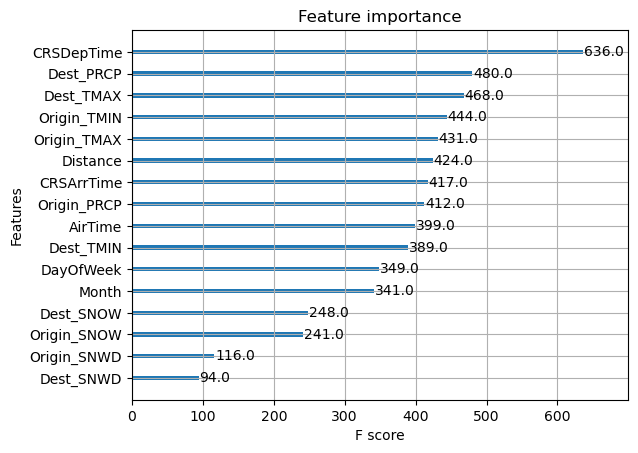

In [45]:
# Plot feature importance
xgb.plot_importance(xgb_reg_mae)
plt.show()

## MAE + Log XGBoost

In [46]:
# Initialize the XGBoost Regressor
xgb_reg_logy_mae = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="mae"
)

In [47]:
# Train the model
xgb_reg_logy_mae.fit(X_train, y_train_transformed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [49]:
### ER - BEGIN ###
with open("../models/xgb_reg_log_mae.pkl", "wb") as file:
    pickle.dump(xgb_reg_logy_mae, file)

In [46]:
with open("../models/xgb_reg_log_mae.pkl", "rb") as file:
    xgb_reg_logy_mae = pickle.load(file)
### ER - END ###

In [47]:
y_pred_transformed = xgb_reg_logy_mae.predict(X_test)
y_pred_logy_mae = np.expm1(y_pred_transformed)  # Reverse transformation

In [48]:
mae = mean_absolute_error(y_test, y_pred_logy_mae)
rmse = root_mean_squared_error(y_test, y_pred_logy_mae)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 32.63179941807334
Root Mean Squared Error (RMSE): 78.61112237103723


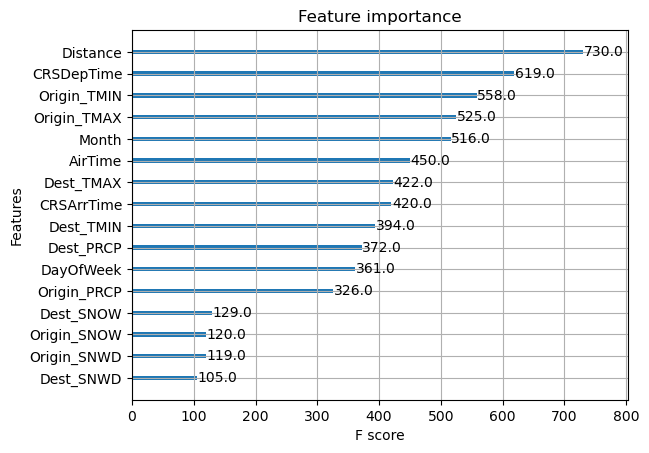

In [50]:
# Plot feature importance
xgb.plot_importance(xgb_reg_logy_mae)
plt.show()

## Residuals

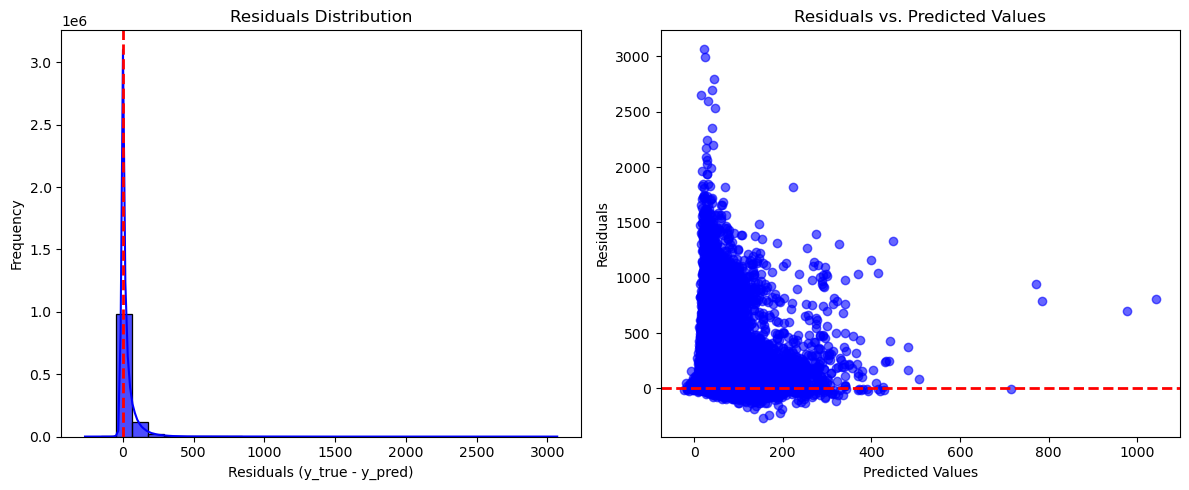

In [51]:
# Compute residuals
residuals = np.array(y_test).flatten() - y_pred_logy_mae

# Plot residuals distribution
plt.figure(figsize=(12, 5))

# Histogram of residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Residuals (y_true - y_pred)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")

# Residuals vs Predictions scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")

plt.tight_layout()
plt.show()


# LGBMRegressor

In [2]:
X_train_raw = pd.read_parquet("../data/final/X_train_enc.parquet")
X_test_raw = pd.read_parquet("../data/final/X_test_enc.parquet")
y_train_raw = pd.read_parquet("../data/final/y_train.parquet")
y_test_raw = pd.read_parquet("../data/final/y_train.parquet")

In [3]:
print(len(X_train_raw))
print(len(X_test_raw))
print(len(y_train_raw))
print(len(y_test_raw))

6105182
1526296
6105182
6105182


In [4]:
X_test_raw.columns

Index(['FlightDate', 'DayOfWeek', 'Month', 'Airline', 'Origin', 'Dest',
       'Cancelled', 'Diverted', 'DivAirportLandings', 'CRSDepTime', 'DepTime',
       'DepDelay', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDel15', 'AirTime',
       'Distance', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn',
       'DelayCategory', 'AirTimeCategory', 'TimeofDay', 'Month_sin',
       'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'DayOfYear',
       'DayOfYear_sin', 'DayOfYear_cos', 'Holiday_Indicator', 'Near_Holiday',
       'Origin_PRCP', 'Origin_SNOW', 'Origin_SNWD', 'Origin_TMAX',
       'Origin_TMIN', 'Dest_PRCP', 'Dest_SNOW', 'Dest_SNWD', 'Dest_TMAX',
       'Dest_TMIN', 'weekly_avg_origin_tmin', 'weekly_avg_dest_tmin',
       'monthly_avg_origin_tmin', 'monthly_avg_dest_tmin',
       'weekly_avg_origin_tmax', 'weekly_avg_dest_tmax',
       'monthly_avg_origin_tmax', 'monthly_avg_dest_tmax',
       'weekly_avg_origin_prcp', 'weekly_avg_dest_prcp',
       'monthly_avg_origin_prcp', 'monthly_avg_d

In [5]:
testing_columns = ['DayOfWeek', 'Month',
                   
                    'Month_sin',
                    'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'DayOfYear',
                    'DayOfYear_sin', 'DayOfYear_cos', 'Holiday_Indicator', 'Near_Holiday',

                    'CRSDepTime', 'CRSArrTime', 'AirTime',
                    'Distance', 'Origin_PRCP', 'Origin_SNOW', 'Origin_SNWD', 
                    'Origin_TMAX', 'Origin_TMIN', 'Dest_PRCP', 'Dest_SNOW', 
                    'Dest_SNWD', 'Dest_TMAX', 'Dest_TMIN', 'weekly_avg_origin_tmin', 'weekly_avg_dest_tmin',
                    'monthly_avg_origin_tmin', 'monthly_avg_dest_tmin',
                    'weekly_avg_origin_tmax', 'weekly_avg_dest_tmax',
                    'monthly_avg_origin_tmax', 'monthly_avg_dest_tmax',
                    'weekly_avg_origin_prcp', 'weekly_avg_dest_prcp',
                    'monthly_avg_origin_prcp', 'monthly_avg_dest_prcp',
                    'weekly_avg_origin_snow', 'weekly_avg_dest_snow',
                    'monthly_avg_origin_snow', 'monthly_avg_dest_snow',
                    'weekly_avg_origin_snwd', 'weekly_avg_dest_snwd',
                    'monthly_avg_origin_snwd', 'monthly_avg_dest_snwd']
training_column = 'DepDelay'

In [6]:
X_test = X_test_raw[testing_columns]
y_test = X_test_raw[training_column]
X_train = X_train_raw[testing_columns]
y_train = X_train_raw[training_column]

## Hyperparameter Tuning

In [7]:
# Define the base LGBM regressor
lgb_reg_holiday = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Traditional boosting
    objective='regression',
    n_jobs=1,  # Use two cores
    random_state=42
)

In [8]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 300, 500, 800],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'num_leaves': [20, 31, 50, 100],  # Leaf nodes per tree (higher = more complex)
    'max_depth': [-1, 5, 10, 15],  # Tree depth (-1 means no limit)
    'min_child_samples': [5, 10, 20],  # Minimum data points in leaf
    'subsample': [0.6, 0.8, 1.0],  # Fraction of data used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularization
}

In [9]:
# Run Randomized Search for hyperparameter tuning
random_search_reg_holiday = RandomizedSearchCV(
    estimator=lgb_reg_holiday,
    param_distributions=param_dist,
    n_iter=10,  # Test 10 random combinations
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=1,
    random_state=42
)

In [ ]:
# Fit the model
random_search_reg_holiday.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
### ER - BEGIN ###
with open("../models/lgbm_reg.pkl", "wb") as file:
    pickle.dump(random_search_reg_holiday, file)

In [ ]:
with open("../models/lgbm_reg.pkl", "rb") as file:
    random_search_reg_holiday = pickle.load(file)
### ER - END ###

In [ ]:
# Print best parameters
print("Best Parameters for LGBMRegressor:", random_search_reg_holiday.best_params_)

# Evaluate on test set
best_regressor_holiday = random_search_reg_holiday.best_estimator_
y_pred_holiday = best_regressor_holiday.predict(X_test)
test_mse_holiday = mean_squared_error(y_test, y_pred_holiday)
print("Test MSE:", test_mse_holiday)

In [ ]:
# Compute residuals
residuals = np.array(y_test).flatten() - y_pred_holiday

# Plot residuals distribution
plt.figure(figsize=(12, 5))

# Histogram of residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Residuals (y_true - y_pred)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")

# Residuals vs Predictions scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")

plt.tight_layout()
plt.show()
